In [ ]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes
using Statistics
using Graphs


@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties

In [ ]:
f=Glob.glob("pseudo2D/500_cells/Final_config","C:\\Documents\\VM_code\\VertexModel\\data\\sims" )[end] #path to folder containing data
files=Glob.glob("systemDataFinal*L₀=*_*ΓA=-0.5_*Γa=0.1*.jld2",f)


17-element Vector{String}:
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 86 bytes ⋯ "=2.0_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 87 bytes ⋯ "2.25_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 86 bytes ⋯ "=2.5_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 87 bytes ⋯ "2.75_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 87 bytes ⋯ "2.85_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 87 bytes ⋯ "2.86_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 88 bytes ⋯ ".875_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 87 bytes ⋯ "2.87_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 88 bytes ⋯ ".885_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 87 bytes ⋯ "2.88_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Documents\\VM_" ⋯ 88 bytes ⋯ ".895_ΓA=-0.5_ΓL=0.1_Γa=0.1.jld2"
 "C:\\Users\\v35431nc\\Docu

In [ ]:
data=[]
evals=[]
et_thresh=0.0005 #edge tension threshold
tensions=[]

for ff in files
    @unpack R, matrices, params = load(ff)
    @unpack nCells,nEdges,nVerts, Γa, ΓA, ΓL, L₀ = params
    @unpack cellAreas, cellPerimeters, cellTensions, cellPositions, A, B= matrices

    med_shapeParameter=median(cellPerimeters./sqrt.(cellAreas))

    edgeTensions=abs.(B)'*cellTensions

    thresholdEdges=zeros(nEdges)
    thresholdEdges[findall(x->abs.(x)>et_thresh,edgeTensions)].=1
    Lth=dropzeros(A'*Diagonal(thresholdEdges)*A)

    Atemp=A[findall(x->abs.(x)>et_thresh,edgeTensions),:]
    newVerts=findall(x->x!=0,vec(sum(abs.(Atemp), dims=1)))
    Anew=Atemp[:,newVerts]

    
    Btemp=B[:,findall(x->abs.(x)>et_thresh,edgeTensions)]
    newCells=findall(x->x!=0,vec(sum(abs.(Btemp), dims=2)))
    Bnew=Btemp[newCells, :]

    Lred=dropzeros(float.(Anew')*float.(Anew))

    vAdjnew=dropzeros(-((Anew'*Anew)-Diagonal(vec(sum(Matrix(abs.(Anew)), dims=1)))))
    gnew=SimpleDiGraph(vAdjnew)
    regions=sort(length.(connected_components(gnew)))
    reg_count=stack([[i, count(==(i), regions)] for i in unique(regions)])


    con_verts=size(Anew)[2]
    con_edges=size(Anew)[1]

    cellPolygons = makeCellPolygons(R,params,matrices)
    edges=[R[findall(x->x!=0, A[j,: ])] for j in 1:nEdges if thresholdEdges[j]!=0]
    verts=reduce(vcat,edges)
    cells=(cellPolygons[newCells])

    fig = Figure()
    ax=Axis(fig[1, 1],aspect=DataAspect())
    hidedecorations!(ax)
    hidespines!(ax)
    for i=1:nCells
        poly!(ax,cellPolygons[i],color=:white, strokecolor=(:black,1.0),strokewidth=0.5)
    end

    for j in 1:length(edges)
        linesegments!(ax,edges[j], color=:red)
    end

    scatter!(verts, color=:blue, markersize=5)

    Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
    resize_to_layout!(fig)
    mkpath(datadir(f,"plots", "edge_tension_threshold_"*string(et_thresh)))
    save(datadir(f,"plots","edge_tension_threshold_"*string(et_thresh),"Connectivity_edges_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".eps"),fig)

    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig2 = Figure()
    a2=Axis(fig2[1,1],  xlabel="component size", ylabel="count")
    barplot!(a2,reg_count[1,:], reg_count[2,:])
    Label( fig2[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
    save(datadir(f,"plots","edge_tension_threshold_"*string(et_thresh),"connected_components_by_size_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig2)


    evalLth, evecLth=LAPACK.syev!('V','U',deepcopy(Matrix(Lth)))

    evalLred, evecLred=LAPACK.syev!('V','U',deepcopy(Matrix(Lred)))

    nZeroEvLth=length(evalLth[evalLth.<=1e-6])
    nZeroEvLred=length(evalLred[evalLred.<=1e-6])

    push!(data,[L₀, Γa, ΓA, ΓA, nCells, nEdges, nVerts,med_shapeParameter, con_edges, con_verts, nZeroEvLth, nZeroEvLred, maximum(regions) ])
    push!(tensions, [minimum(cellTensions), maximum(cellTensions), mean(cellTensions), median(cellTensions),std(cellTensions), minimum(edgeTensions), maximum(edgeTensions), mean(edgeTensions), median(edgeTensions), std(edgeTensions)])
    push!(evals,evalLth)
end

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\pdSa4\src\data\reconstructing_datatypes.jl:574
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\pdSa4\src\data\reconstructing_datatypes.jl:574
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\pdSa4\src\data\reconstructing_datatypes.jl:574
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\pdSa4\src\data\reconstructing_datatypes.jl:574
┌ Warning: type VertexModel...\VertexModelContainers.jl.

ArgumentError: ArgumentError: `stack` on an empty collection is not allowed

In [5]:
data_all=stack(float.(data))
tensions=stack(float.(tensions))

10×16 Matrix{Float64}:
 0.0623803  0.0481969   0.0333831  0.00803768  …  -3.09011e-6   -0.000100507
 0.140416   0.0978387   0.0592685  0.0266052       0.00422033    0.0102289
 0.105134   0.0741135   0.0439197  0.0146907       4.48586e-5    0.000302582
 0.104706   0.073321    0.0427905  0.0144941       1.05091e-8    8.90639e-7
 0.0120225  0.00792335  0.0048255  0.00344165      0.000420345   0.00125466
 0.0992506  0.0692466   0.0388731  0.00883894  …  -4.61568e-6   -5.58672e-5
 0.266364   0.189082    0.117018   0.0513205       0.00465186    0.0160642
 0.202041   0.142153    0.0839772  0.0277653       5.83534e-5    0.000513285
 0.210117   0.147531    0.0863359  0.028124        1.75462e-8    3.07702e-6
 0.0357286  0.0251162   0.0153556  0.00725712      0.000479386   0.00191861

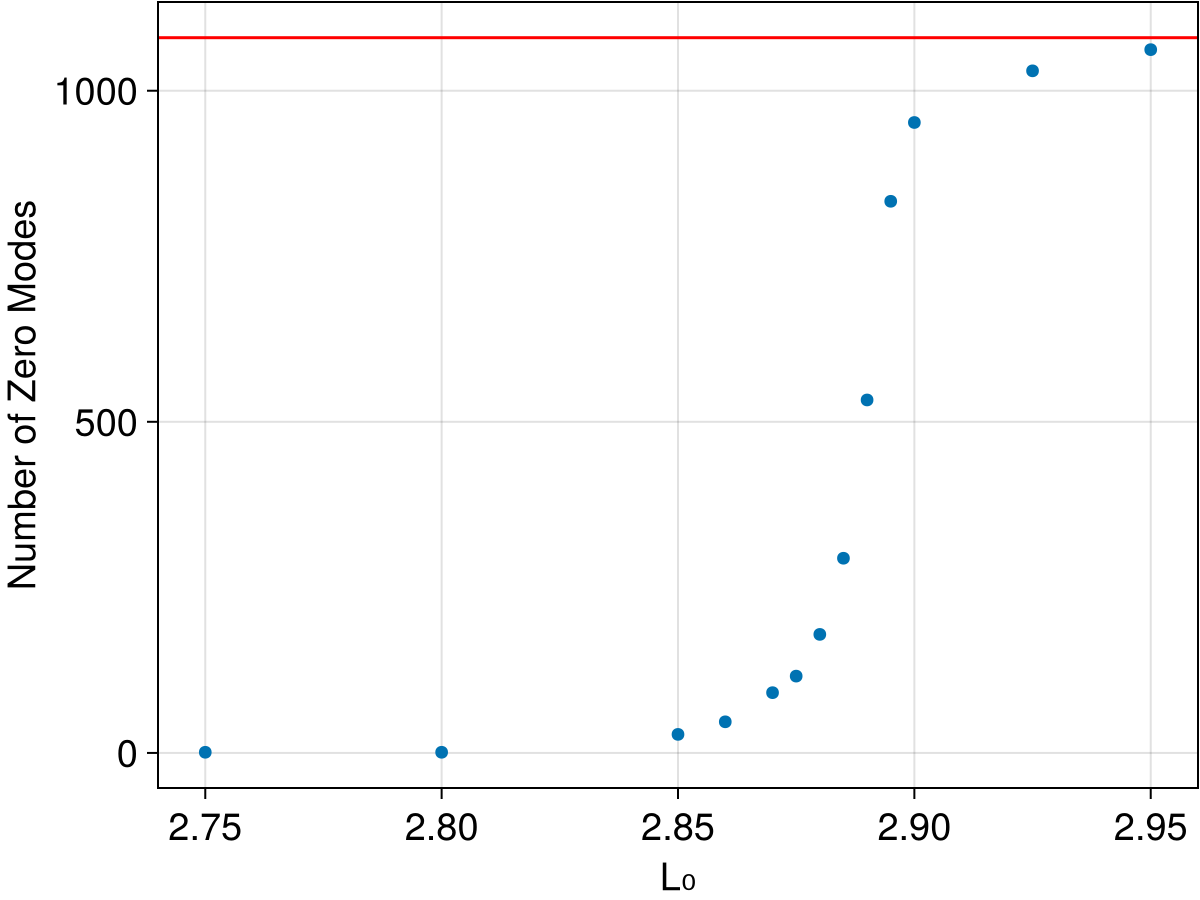

In [38]:
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
a1=Axis(fig[1,1],  xlabel="L₀", ylabel="Number of Zero Modes")

scatter!(a1,data_all[1,4:end], data_all[end-2,4:end] )

hlines!(1080, color=:red)

save(datadir(f,"plots","edge_tension_threshold_"*string(et_thresh),"Zero_modes_Lepsilon.png"),fig)

fig


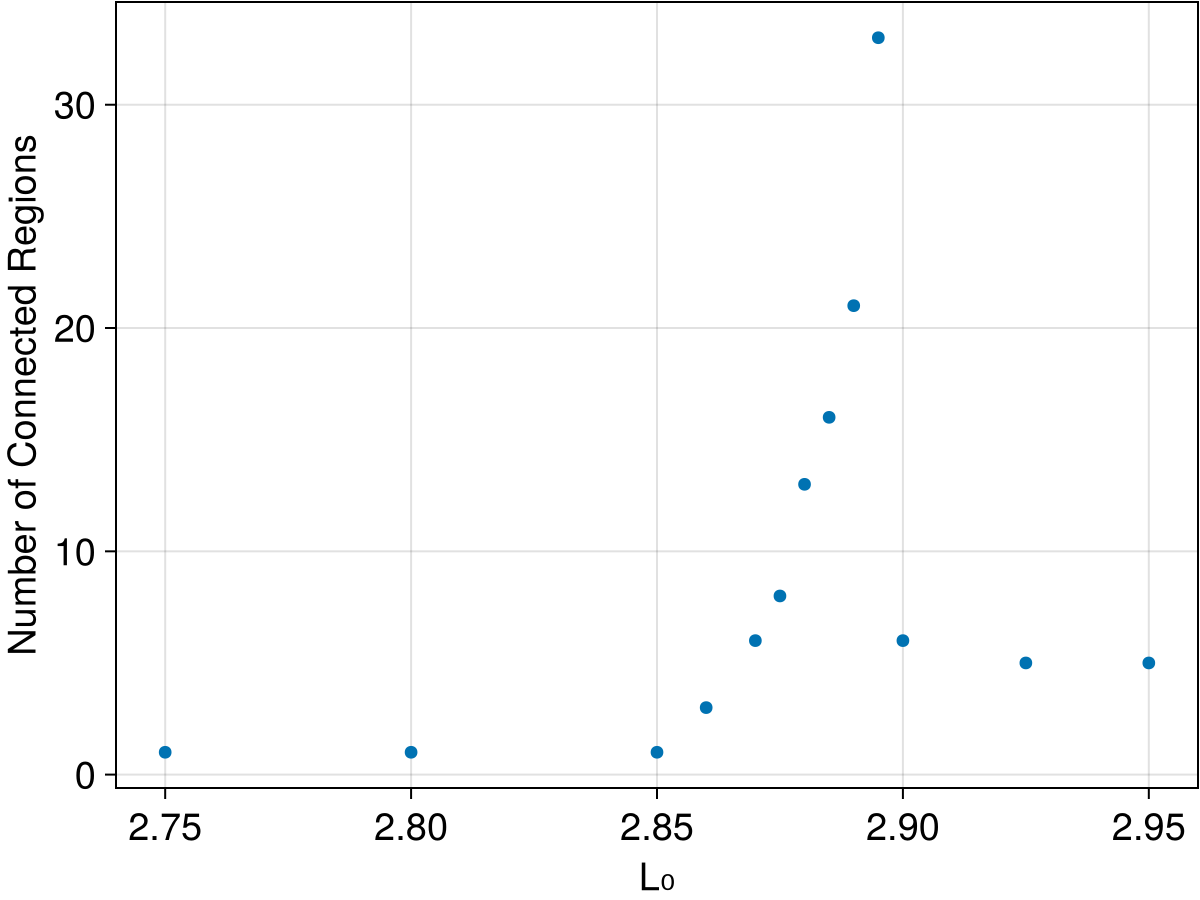

In [39]:
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
a1=Axis(fig[1,1],  xlabel="L₀", ylabel="Number of Connected Regions")

scatter!(a1,data_all[1,4:end], data_all[end-1,4:end] )

#hlines!(1080, color=:red)

save(datadir(f,"plots","edge_tension_threshold_"*string(et_thresh),"Connected_Regions_Lepsilon.png"),fig)

fig

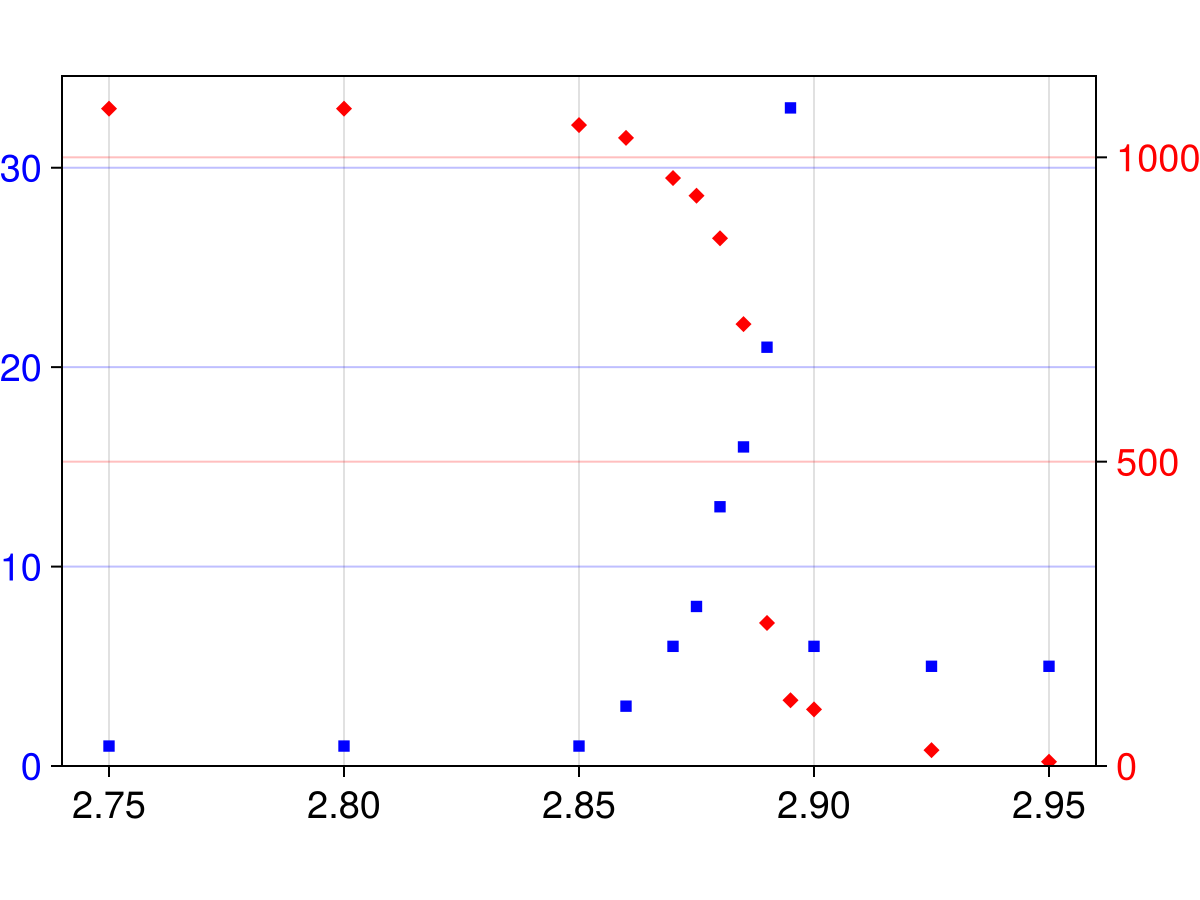

In [80]:

fig = Figure()

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Arial", fontsize=19, )

ax1 = Axis(fig[1, 1], yticklabelcolor = :blue,
        ygridcolor=(:blue,0.25), aspect=1.5)
ax2 = Axis(fig[1, 1], yticklabelcolor = :red, yaxisposition = :right, ygridcolor=(:red, 0.25), aspect=1.5)
hidespines!(ax2)
hidexdecorations!(ax2)


scatter!(ax1,data_all[1,4:end], data_all[end-1,4:end], color=:blue, marker=:rect)

scatter!(ax2,data_all[1,4:end], data_all[end,4:end], color=:red, marker=:diamond )

ylims!(ax1, 0, nothing)
ylims!(ax2, 0, nothing)
save(datadir(f,"plots","edge_tension_threshold_"*string(et_thresh),"Connected_Regions_Region_size_Lepsilon.eps"),fig)
fig

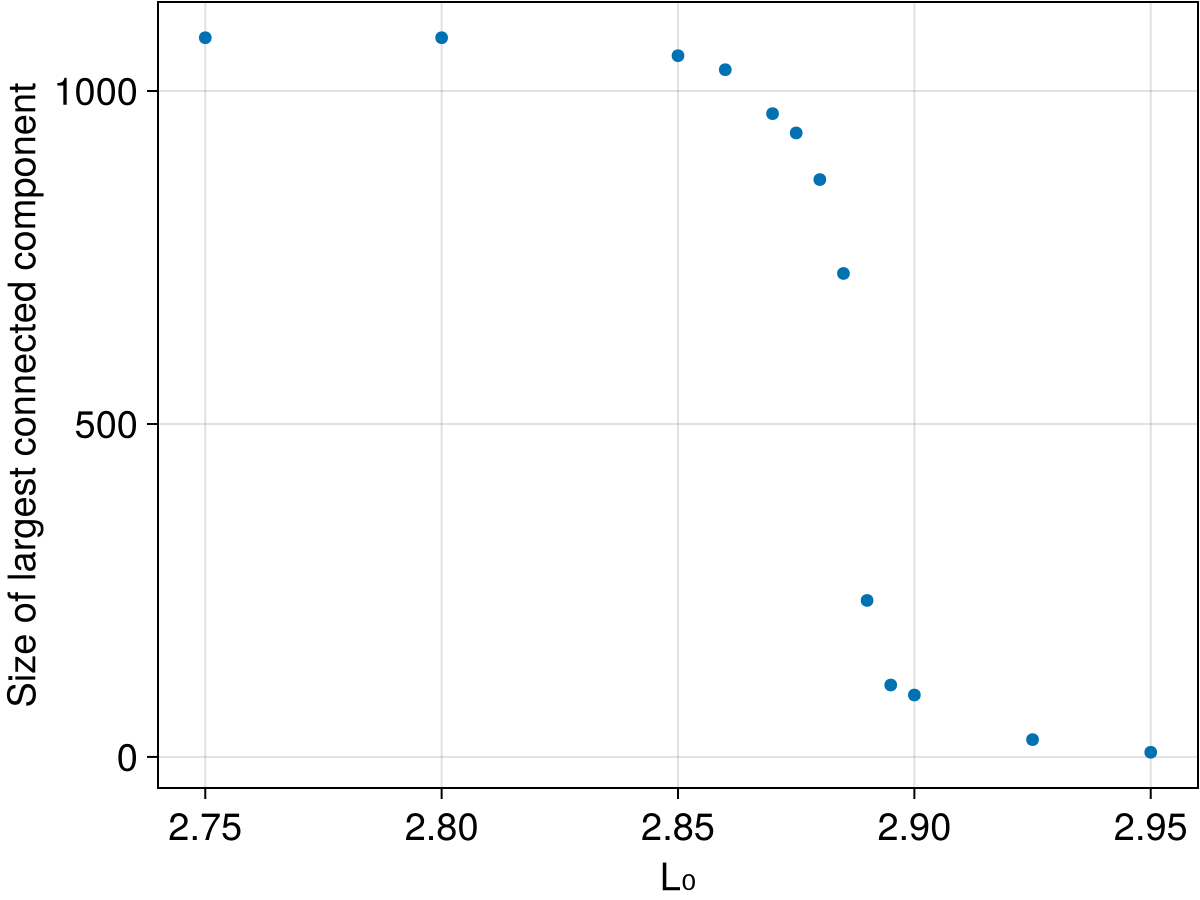

In [41]:
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
a1=Axis(fig[1,1],  xlabel="L₀", ylabel="Size of largest connected component")

scatter!(a1,data_all[1,4:end], data_all[end,4:end] )

#hlines!(1080, color=:red)

save(datadir(f,"plots","edge_tension_threshold_"*string(et_thresh),"Largest_Region_Lepsilon.png"),fig)
fig

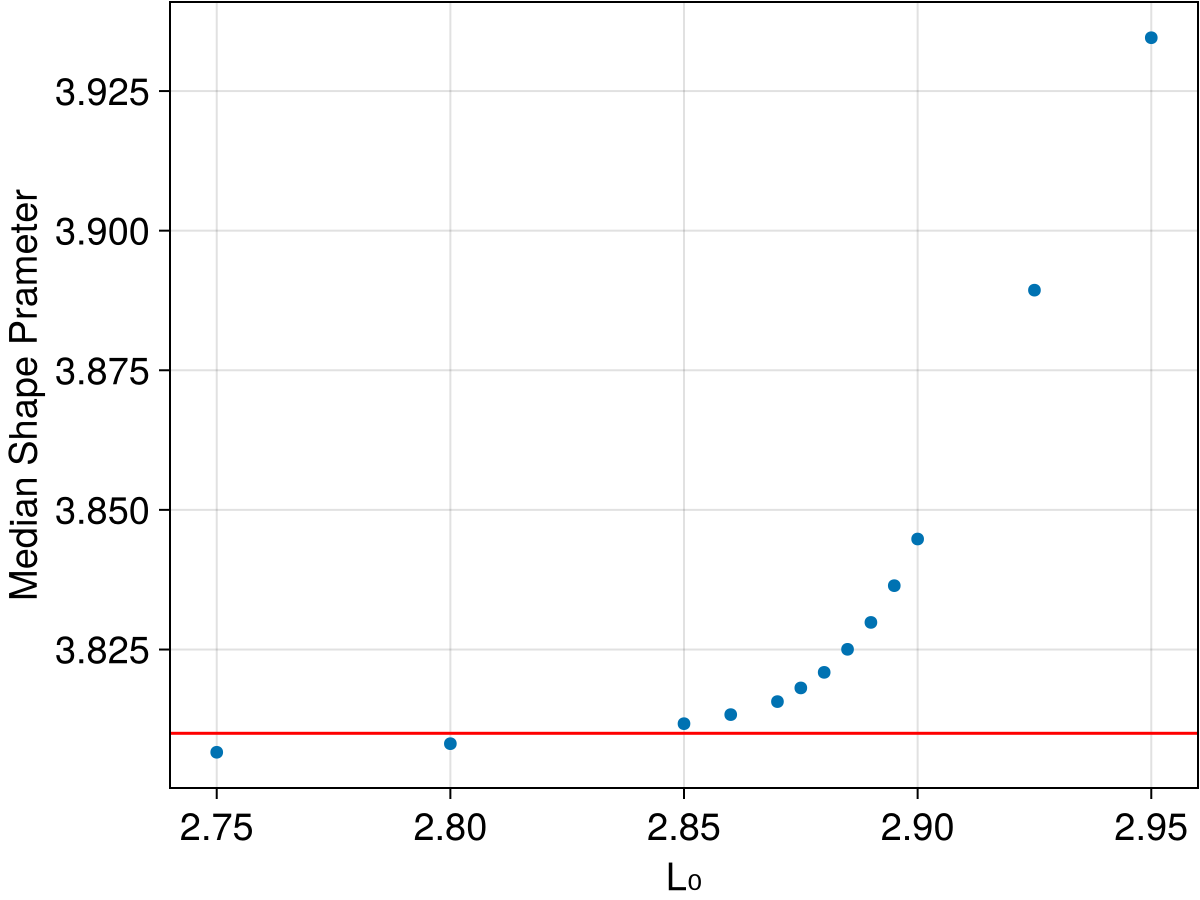

In [31]:
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
a1=Axis(fig[1,1],  xlabel="L₀", ylabel="Median Shape Prameter")

scatter!(a1,data_all[1,4:end], data_all[8,4:end] )

hlines!(3.81, color=:red)

save(datadir(f,"plots","edge_tension_threshold_"*string(et_thresh),"Median_Shape_parameter.png"),fig)

fig

In [1]:
Evals=stack(evals)
ev_plot=Evals[:,findall(x->x in [2.8, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.95],data_all[1,:])]
L_0_plot=data_all[1,findall(x->x in [2.8, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.95],data_all[1,:])]

UndefVarError: UndefVarError: `evals` not defined in `Main`
Suggestion: check for spelling errors or missing imports.